<a href="https://colab.research.google.com/github/jayaemekar/CSCI-611-AppiledMachineLearning/blob/main/PathToHerdImmunity_ProphetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path To Herd Immunity -Covid 19 Prediction using Prophet
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 Path to Herd Immunity via
Time Series Analysis

# NOTEBOOK INCLUDES
 1. Data Preparation including cleaning and Missing data
 2. Exploratory data analysis on complete world vaccination data 
 3. Exploration of Prophet 



# Import necessary libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet

# Import geopandas for ploting of world map

In [54]:
!pip install geopandas

In [55]:
#import geo data
import geopandas as gpd

# Load the data take the latest data(updated last month) which contains all columns

In [56]:
#Load data from git
covid_data = pd.read_csv('/content/owid-covid-data.csv')

In [57]:
#check top 5 columns to get a gist of data
covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [58]:
#check columns
covid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [59]:
#only retain the required columns
column_list = ['iso_code', 'continent','location' , 'date', 'people_fully_vaccinated_per_hundred', 'life_expectancy', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'population', 'population_density','gdp_per_capita','new_cases_per_million' ]

In [60]:
#load the data again with required columns
covid_df = pd.read_csv('/content/owid-covid-data.csv', usecols=column_list)

In [61]:
covid_df.shape

(79479, 15)

In [62]:
#Check how many countries are present in the dataset
covid_df['location'].nunique()

215

In [63]:
#check for all missing values in data
covid_df.isnull().sum()

iso_code                                   0
continent                               3877
location                                   0
date                                       0
new_cases_per_million                   2006
total_vaccinations                     73205
people_vaccinated                      73820
people_fully_vaccinated                75525
total_vaccinations_per_hundred         73205
people_vaccinated_per_hundred          73820
people_fully_vaccinated_per_hundred    75525
population                               494
population_density                      5393
gdp_per_capita                          7322
life_expectancy                         4025
dtype: int64

**As can be seen, there is quite much missing data. Let's drop total_vaccinations missing data and people vaccinated missing data, as without this value any raw doesn't make much sense**


In [64]:
#drop missing data
covid_df = covid_df.drop(covid_df[covid_df.total_vaccinations.isna()].index)

In [65]:
#drop missing data
covid_df = covid_df.drop(covid_df[covid_df.people_vaccinated.isna()].index)

In [66]:
# Print basic statics of data
cm = sns.light_palette("blue", as_cmap=True)
covid19_stats = covid_df.describe().style.background_gradient(cmap=cm)
display(covid19_stats)

,new_cases_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density,gdp_per_capita,life_expectancy
count,5275.000000,5586.000000,5586.000000,3953.000000,5586.000000,5586.000000,3953.000000,5585.000000,4887.000000,4716.000000,4914.000000
mean,222.326825,10960875.909058,6904397.480666,3381497.023779,9.685247,6.900211,3.892039,358518150.406088,511.473347,29806.220416,77.949459
std,255.231696,43974723.988739,25644289.609709,11717710.651671,18.518763,11.778802,8.483044,1264124471.731101,2130.169342,19075.833902,5.075187
min,-1590.147000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3483.000000,0.137000,1095.042000,54.690000
25%,43.887000,53065.750000,44248.750000,23919.000000,0.690000,0.580000,0.320000,5421242.000000,45.135000,15469.207000,75.400000
50%,148.826000,435760.000000,329251.000000,210279.000000,3.655000,2.860000,1.460000,16743930.000000,104.700000,27216.445000,78.740000
75%,305.133000,3022479.750000,2305639.250000,1316574.000000,11.005000,8.120000,3.700000,83783945.000000,231.447000,40585.721000,81.910000
max,2186.292000,664643866.000000,370325173.000000,144264780.000000,180.780000,95.850000,84.930000,7794798729.000000,20546.766000,104861.851000,86.750000


**The bigger the value, the darker the background color. in each column the numbers are given shade. We can see GDP per capita has the maximum varient data**






In [67]:
#we can easily do mean for population, life expectancy , gdp_per_capita and population_density
covid_df['population'] = covid_df['population'].fillna(covid_df['population'].mean())
covid_df['life_expectancy'] = covid_df['life_expectancy'].fillna(covid_df['life_expectancy'].mean())
covid_df['gdp_per_capita'] = covid_df['gdp_per_capita'].fillna(covid_df['gdp_per_capita'].mean())
covid_df['population_density'] = covid_df['population_density'].fillna(covid_df['population_density'].mean())


**Ploting HeatMap**

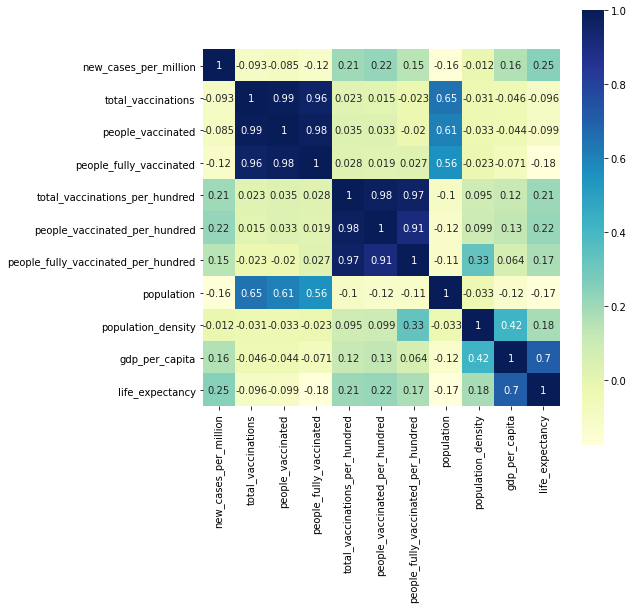

In [68]:
plt.subplots(figsize=(8, 8))
sns.heatmap(covid_df.corr(), annot=True, square=True,  cmap="YlGnBu")
plt.show()



*   **WE can observe total vaccinated, people vaccinated  and people fully vaccinated are closly related**
*   **Total vaccination per hundred people vaccinated per hundred and people full vaccinated per hunderd are closly related**




As total vaccinations and people vaccinated related lets do mannwhitneyu to find the pvalue

In [69]:
scipy.stats.mannwhitneyu(covid_df.total_vaccinations, covid_df.people_vaccinated, alternative='two-sided')

MannwhitneyuResult(statistic=16392974.5, pvalue=3.4454238324561693e-06)

As total vaccinations and people vaccinated related lets do mannwhitneyu to find the pvalue

In [70]:
scipy.stats.mannwhitneyu(covid_df.total_vaccinations_per_hundred, covid_df.people_vaccinated_per_hundred, alternative='two-sided')

MannwhitneyuResult(statistic=16824449.0, pvalue=7.291183039521763e-13)

We will keep both this values as they are important so we will find a difference of mean and assign it to the respective values

In [71]:
#compute the difference of mean
diff = covid_df.total_vaccinations.mean() - covid_df.people_vaccinated.mean()
diff_per_hundred = covid_df.total_vaccinations_per_hundred.mean() - covid_df.people_vaccinated_per_hundred.mean()

#assign the values substracting the difference of mean
covid_df.people_vaccinated = covid_df.people_vaccinated.fillna(covid_df.total_vaccinations - diff)
covid_df.people_vaccinated_per_hundred = covid_df.people_vaccinated_per_hundred.fillna(covid_df.total_vaccinations_per_hundred - diff_per_hundred)

In [72]:
covid_df.isna().sum()

iso_code                                  0
continent                               763
location                                  0
date                                      0
new_cases_per_million                   311
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                1633
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred    1633
population                                0
population_density                        0
gdp_per_capita                            0
life_expectancy                           0
dtype: int64

**We will be assuming that people require two vaccination for terming them as fully vaccinated**



In [73]:
#Fill NaN values for 'people_fully_vaccinated'
#Assume that people require 2 vaccinations
covid_df['people_fully_vaccinated'] =  np.where(covid_df['people_fully_vaccinated'].isna(),
                                                   (covid_df['people_vaccinated'] /2)  ,
                                                   covid_df['people_fully_vaccinated'])

In [74]:
#Fill NaN values for 'people_fully_vaccinated_per_hundred'
#Assume that people require 2 vaccinations
covid_df['people_fully_vaccinated_per_hundred'] =  np.where(covid_df['people_fully_vaccinated_per_hundred'].isna(),
                                                   (covid_df['total_vaccinations_per_hundred'] /2)  ,
                                                   covid_df['people_fully_vaccinated_per_hundred'])

In [75]:
#find the null values again to check if everything was fine
covid_df.isna().sum()

iso_code                                 0
continent                              763
location                                 0
date                                     0
new_cases_per_million                  311
total_vaccinations                       0
people_vaccinated                        0
people_fully_vaccinated                  0
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred            0
people_fully_vaccinated_per_hundred      0
population                               0
population_density                       0
gdp_per_capita                           0
life_expectancy                          0
dtype: int64

In [76]:
#fill missing values of continent as other
covid_df['continent'] = covid_df['continent'].fillna('Other')

In [77]:
# Print basic statics of data again 
covid19_stats = covid_df.describe().style.background_gradient('inferno')
display(covid19_stats)

,new_cases_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density,gdp_per_capita,life_expectancy
count,5275.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000
mean,222.326825,10960875.909058,6904397.480666,2438211.541264,9.685247,6.900211,3.117506,358518150.406088,511.473347,29806.220416,77.949459
std,255.231696,43974723.988739,25644289.609709,9968685.692213,18.518763,11.778802,7.448898,1264011295.270716,1992.412568,17527.210078,4.760075
min,-1590.147000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3483.000000,0.137000,1095.042000,54.690000
25%,43.887000,53065.750000,44248.750000,12762.250000,0.690000,0.580000,0.125000,5421242.000000,58.045000,17336.469000,75.930000
50%,148.826000,435760.000000,329251.000000,87191.000000,3.655000,2.860000,0.842500,16743930.000000,113.128000,29806.220416,77.949459
75%,305.133000,3022479.750000,2305639.250000,592857.750000,11.005000,8.120000,3.010000,83783945.000000,402.606000,38605.671000,81.540000
max,2186.292000,664643866.000000,370325173.000000,144264780.000000,180.780000,95.850000,84.930000,7794798729.000000,20546.766000,104861.851000,86.750000


In [78]:
#checking the head again to see if everything is fine
covid_df.head()

,iso_code,continent,location,date,new_cases_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density,gdp_per_capita,life_expectancy
364,AFG,Asia,Afghanistan,2021-02-22,0.334,0.0,0.0,0.0,0.00,0.00,0.00,3.892834e+07,54.422000,1803.987000,64.830000
370,AFG,Asia,Afghanistan,2021-02-28,0.180,8200.0,8200.0,4100.0,0.02,0.02,0.01,3.892834e+07,54.422000,1803.987000,64.830000
386,AFG,Asia,Afghanistan,2021-03-16,0.257,54000.0,54000.0,27000.0,0.14,0.14,0.07,3.892834e+07,54.422000,1803.987000,64.830000
737,OWID_AFR,Other,Africa,2021-01-09,26.182,0.0,0.0,0.0,0.00,0.00,0.00,1.340598e+09,511.473347,29806.220416,77.949459
741,OWID_AFR,Other,Africa,2021-01-13,25.360,2000.0,2000.0,1000.0,0.00,0.00,0.00,1.340598e+09,511.473347,29806.220416,77.949459


# Vaccination rates by continent, by life expectancy, population etc

**Plot graph for people fully vaccinated oer hundred based on dates**

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


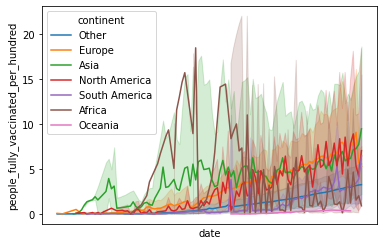

In [79]:
#use lineplot to plot data 
graph = sns.lineplot(data= covid_df.sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='continent')
graph.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation = 90)
plt.show()

We can see as more and more time passing by various countries are progressing on vaccinated people 


1.   We see a good linear progress in North America Graph
2.   People are hardly vaccinated in Oceania 
3.   Graph for Asia, Europe and North America is more or less close to each other





INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


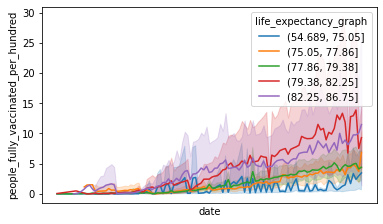

In [80]:
covid_df['life_expectancy_graph'] = pd.qcut(covid_df['life_expectancy'],q=5)
graph = sns.lineplot(data=covid_df.sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='life_expectancy_graph')
graph.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
graph.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation = 90)
plt.gcf().autofmt_xdate()
plt.show()

* We can observe that as people are getting vaccinated life 
expectancy is also linearly increasing 
* Life expectancy is the average time a person lives 
* We can observe that in all cases are time is passing by and people started to get vaccine life expectancy is increasing 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


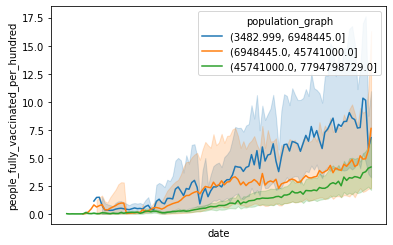

In [81]:
covid_df['population_graph'] = pd.qcut(covid_df['population'],q=3)
graph = sns.lineplot(data=covid_df.sort_values(by='date'), x='date', 
                     y='people_fully_vaccinated_per_hundred',hue='population_graph')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

We can observe that 
* Population is increasing as days are passing and as number of vaccinated people are getting increased 
* We have grouped in three groups population before and as days are going by 



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


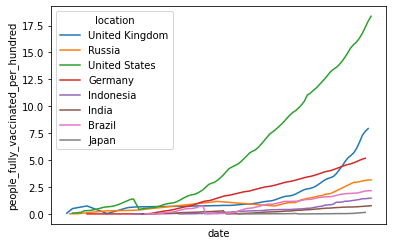

In [82]:
graph = sns.lineplot(data=covid_df[covid_df['iso_code'].isin(['GBR','IDN','BRA','RUS','DEU','JPN','IND','USA','CHN'])].sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='location')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

Randomly decided on 8 countries and checked the vaccination rate
* For United States it is getting increased day by day
* The least vaccination is in Japan 
* Russia had and average vaccinated rate 



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


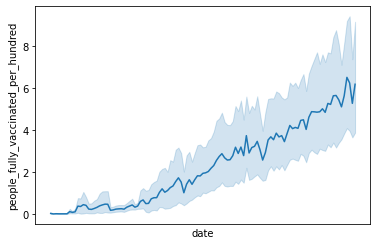

In [83]:
#Overall plot
graph = sns.lineplot(data=covid_df.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred")
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

We have plotted the overall plot here:
* Overall the number of vaccinated people in the world is increasing day by day and we have a linear increase in graph



## Map plot based on country map

In [84]:
#we will read in data for plotting map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [85]:
#as we already have continent in our data we will drop that column
del world['continent']

In [86]:
#We will join both the data for covid and world map and join it on iso_code
mapped = world.set_index('iso_a3').join(covid_df.set_index('iso_code')).reset_index()

In [87]:
#function to create map graph
def graph_world(feature):
    #whichever data we wish to map we will send in feature
    to_be_mapped = feature
    vmin, vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(25,25))

    mapped.plot(column=to_be_mapped, cmap='inferno', linewidth=0.8, ax=ax, edgecolors='0.8')
    ax.set_title('x', fontdict={'fontsize':30})
    ax.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal')

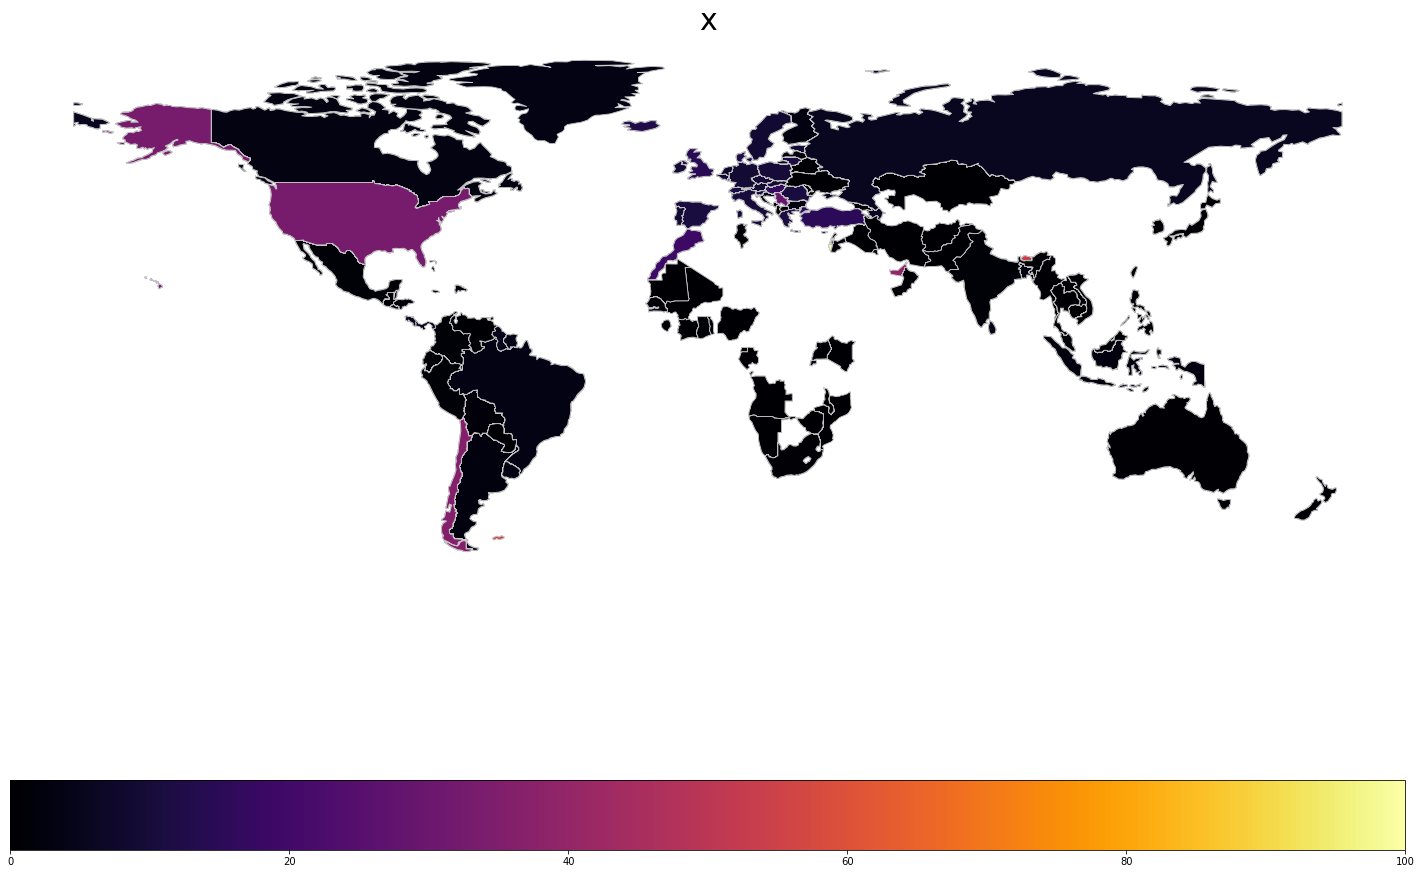

In [88]:
#we will send data for full vaccinated people per hundred
graph_world('people_fully_vaccinated_per_hundred')

#Prediction of vactionation rate

We will find the top 10 country which were vaccinated recently 

In [89]:
top_10_vacc = list(covid_df[(~covid_df['people_fully_vaccinated_per_hundred'].isna())&(covid_df['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['iso_code'])

In [90]:
top_10_vacc

['GIB', 'ISR', 'CHL', 'USA', 'JEY', 'BHR', 'SRB', 'BTN', 'MLT', 'OWID_NAM']

In [91]:
top_10_contry = list(covid_df[(~covid_df['people_fully_vaccinated_per_hundred'].isna())&(covid_df['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['iso_code'])

In [92]:
top_10_contry

['GIB', 'ISR', 'CHL', 'USA', 'JEY', 'BHR', 'SRB', 'BTN', 'MLT', 'OWID_NAM']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


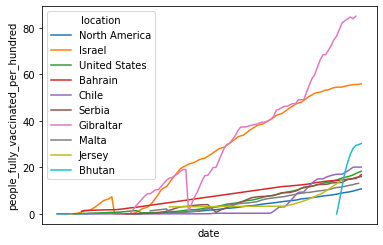

In [93]:
#10 countries in the world vaccination rates
graph = sns.lineplot(data=covid_df[covid_df['iso_code'].isin(top_10_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='location')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

We can observe that Israel is at the second position and Gibraltar at the top for vaccination rate




In [94]:
def fcast(cntry):
    p = covid_df[covid_df['iso_code'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%02d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2022-%02d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))
    # plot forecast
    model.plot(forecast)
    plt.ylim(0, 100)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

In [100]:
def fcastInfection(cntry):
    p = covid_df[covid_df['iso_code'].isin([cntry])].sort_values(by="date")[['date',"new_cases_per_million"]]
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%02d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2022-%02d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))
    # plot forecast
    model.plot(forecast)
    plt.ylim(0, 100)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of new_cases_per_million: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

##Forecast for India

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.018904   -0.057857    0.094143
1 2021-02-01  0.084119    0.006185    0.159551
2 2021-03-01  0.211826    0.135280    0.291747
3 2021-04-01  0.696926    0.623213    0.767924
4 2021-05-01  1.134425    1.047538    1.217820
5 2021-06-01  1.606090    1.460330    1.747239
6 2021-07-01  2.070902    1.825898    2.303898
7 2021-08-01  2.529404    2.129566    2.901195
8 2021-09-01  2.998590    2.454236    3.498435
9 2021-10-01  3.464720    2.747320    4.114332


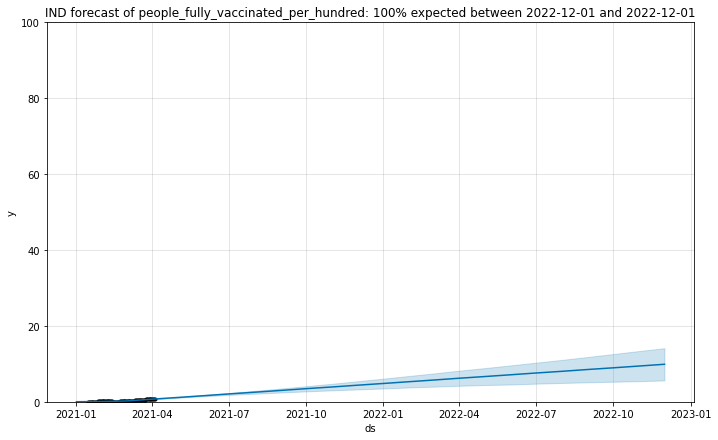

In [96]:
fcast('IND')

Prediction for when India will get fully vaccinated depending on the current rate
India will be 100% vaccinated around end of 2022 

---



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01   11.414047    8.361631   14.465727
1 2021-02-01    5.507913    2.553766    8.575523
2 2021-03-01    8.076953    5.076131   10.911264
3 2021-04-01   57.589447   54.662348   60.532431
4 2021-05-01  122.394776  115.526230  129.511265
5 2021-06-01  186.336049  164.080731  206.437972
6 2021-07-01  254.334434  214.932556  293.600867
7 2021-08-01  321.543806  256.940986  383.223978
8 2021-09-01  387.732661  299.236249  475.740559
9 2021-10-01  453.280659  333.116909  568.738744


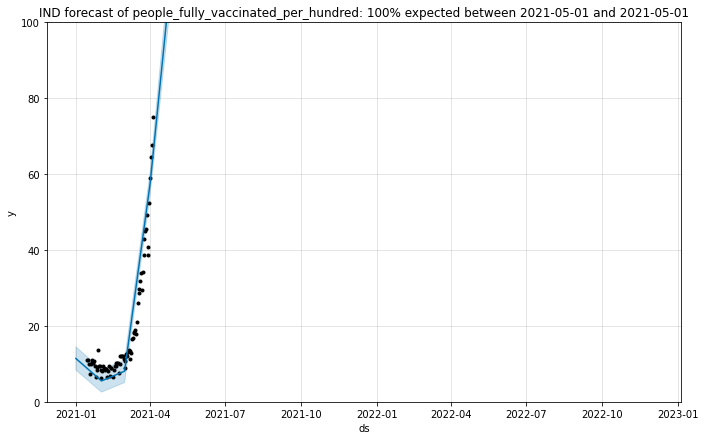

In [97]:
fcastInfection("IND")


##Forecast For USA

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.540571    0.358890    0.719605
1 2021-02-01   1.806161    1.625528    1.986667
2 2021-03-01   7.608698    7.430263    7.807362
3 2021-04-01  16.702210   16.531838   16.889379
4 2021-05-01  26.726437   25.640020   27.839333
5 2021-06-01  36.796222   33.574738   40.312356
6 2021-07-01  46.577652   40.311109   53.245386
7 2021-08-01  56.973110   47.356699   67.364911
8 2021-09-01  66.947788   53.270687   81.926365
9 2021-10-01  76.847023   58.442715   95.842324


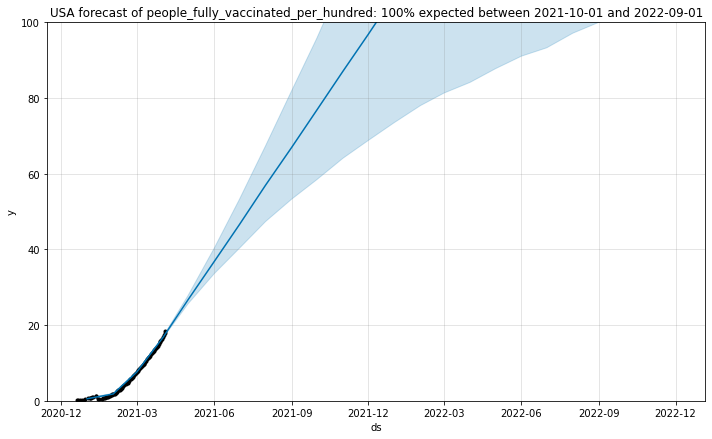

In [98]:
fcast('USA')

Prediction for when USA will get fully vaccinated depending on the current rate
USA will be 100% vaccinated around end of 2021

---



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  753.242293  672.682160  834.097179
1 2021-02-01  355.090632  277.130487  433.726611
2 2021-03-01  157.104906   79.276988  235.372042
3 2021-04-01  200.896064  127.494160  281.925999
4 2021-05-01  110.158433   25.903154  192.405279
5 2021-06-01   44.667788  -57.359320  146.403928
6 2021-07-01   46.064480 -104.706220  169.654330
7 2021-08-01 -132.913299 -349.245172   65.021759
8 2021-09-01  -97.714772 -387.627963  176.898257
9 2021-10-01  -97.967621 -485.715190  246.215822


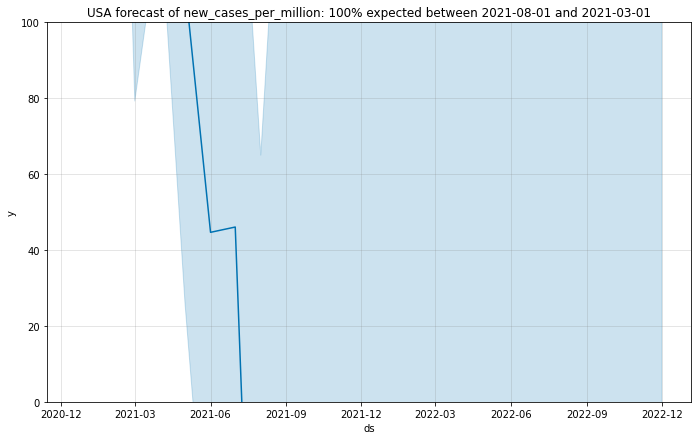

In [101]:
fcastInfection("USA")


##Forecast For ISRALE

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01    2.200051    0.065114    4.353436
1 2021-02-01   19.827300   17.665387   21.945649
2 2021-03-01   40.129657   38.151257   42.281320
3 2021-04-01   57.062547   55.049102   59.329769
4 2021-05-01   70.296916   66.283072   74.784613
5 2021-06-01   84.573351   73.758269   96.503464
6 2021-07-01   98.709169   77.846769  121.655897
7 2021-08-01  112.527279   79.451936  148.849569
8 2021-09-01  126.850429   80.383946  177.479123
9 2021-10-01  140.654229   79.389724  205.793668


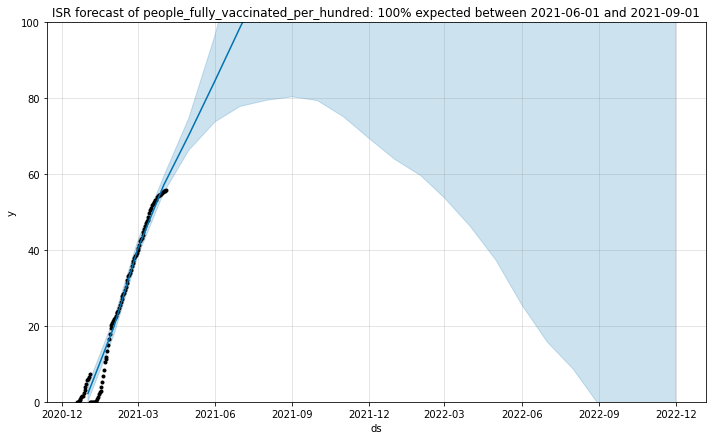

In [99]:
fcast('ISR')

Prediction for when Israel will get fully vaccinated depending on the current rate
Israel will be 100% vaccinated around end of starting of 2021

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds         yhat   yhat_lower   yhat_upper
0 2021-01-01   657.971293   412.761120   904.675111
1 2021-02-01   679.901466   431.246340   922.738578
2 2021-03-01   412.783444   150.900611   659.059150
3 2021-04-01   131.759001  -118.276148   376.383749
4 2021-05-01  -310.842403  -563.984142   -71.197074
5 2021-06-01  -430.019009  -683.446977  -171.316490
6 2021-07-01  -759.741358 -1061.545446  -482.128153
7 2021-08-01 -1212.229249 -1524.307796  -855.095655
8 2021-09-01 -1314.209026 -1718.024268  -897.141079
9 2021-10-01 -1784.169984 -2240.154263 -1291.455836


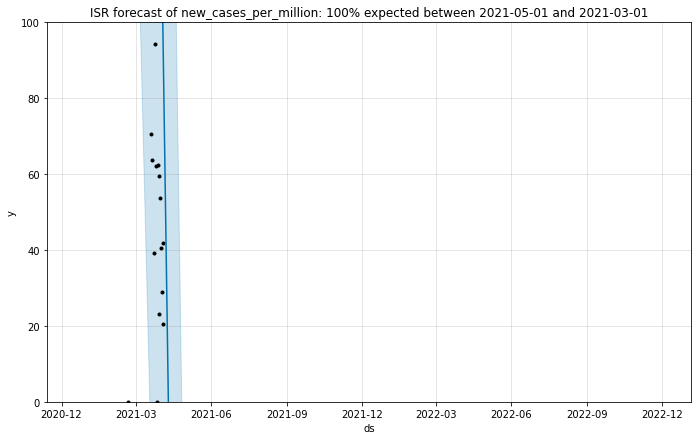

In [102]:
fcastInfection("ISR")
